<a href="https://colab.research.google.com/github/ankanghosh/twitter-sentiment-classification-with-tinybert/blob/main/TwitterSentimentClassificationUsingTinyBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Twitter Sentiment Classification

## Motivation

We will use the [Sentiment140 dataset](http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip) to classify the sentiment of Twitter messages using a light-weight, faster, and distilled form of Google's [Bidirectional Encoder Representations from Transformers](https://arxiv.org/abs/1810.04805) (BERT) model, known as [TinyBERT](https://arxiv.org/abs/1909.10351). The goal is to fine-tune the pre-trained TinyBERT model with the data for sentiment classification and leverage the rich capabilities of TinyBERT by updating the weights, embeddings, and complex text representations it has already learnt.

While Twitter has been rebranded to *X*, the messages in the dataset are from 2009, when Twitter was *Twitter* and tweets were limited to 140 characters. We will therefore refer to *X* as *Twitter* in this work.

Sentiment140 allows us to discover the sentiment of a brand, product, or topic on Twitter.

Each of the training and test data comprise of a CSV file with emoticons removed. More [here](https://www.tensorflow.org/datasets/catalog/sentiment140).

Note: The [TensorFlow dataset link](https://www.tensorflow.org/datasets/catalog/sentiment140) does state that the labels included in the dataset are 0 *(negative)*, 2 *(neutral)*, and 4 *(positive)*. However, the training dataset currently contains the labels 0 *(negative)* and 4 *(positive)*. The test dataset additionally contains the label 2 *(neutral)*, apart from 0 *(negative)* and 4 *(positive)*.

## Data and computing resources

We will first go ahead and [download](http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip) the data and upload it in Google Drive. Of course, we could use the local Colab environment to store the data. However, the data is roughly of 240 MB in size (~ 1.6 million tweets) and uploading the same to Colab everytime the runtime restarts or is disconnected or is reassigned is not worth the wait.

Additionally, we will require a considerable amount of computing power or RAM for processing the data (text tokenization) and for fitting the final neural network model with TinyBERT (sentiment classifier), which is not available with the free tier of Colab. We will therefore need to [upgrade](https://colab.research.google.com/signup) to *Colab Pro* or go for *Pay As you Go*, as we will need to use a GPU or a TPU to process the data and to build the model.

We will be using a TPU in this work, as it is relatively cheaper than the GPUs available in the Colab environment and also because we would be leveraging TensorFlow's distributed computing capacity to optimize the training time and resources. This can be achieved by navigating as follows.
*   Go to Runtime --> Change runtime type -->
Select TPU v2 under Hardware accelerator.

We can always monitor the usage of the resources we have selected as follows.
*   Go to Runtime --> View resources.

## Getting started

With about ~1.6 million tweets to be trained by fine-tuning TinyBERT that itself has about 14 million parameters or weights to be updated, we are looking at huge costs in terms of computation and time. To optimize the use of computational resources and to minimize the time and cost required to train our final model, which will be a combination of TinyBERT and a basic, shallow neural network that we will create, we will use distributed computing or parallel processing on a TPU. Let us go ahead and install the `tensorflow-addons` package required to achieve parallelization.

In [1]:
!pip install tensorflow-addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 2.5 MB/s eta 0:00:00


Let us load the relevant Python libaries.

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers.schedules import PolynomialDecay
import tensorflow_addons as tfa
from transformers import BertTokenizer, TFBertForSequenceClassification
from google.colab import drive
import pandas as pds
import csv
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

tf.get_logger().setLevel('ERROR')

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Fetch and read the data

Define the paths to import the training and test data from Google Drive. Additionally, we'll also create cleaned-up versions of our training and test data and save those in the same folder on Google Drive as the datasets.

In [3]:
# Import the dataset from Google Drive.
drive.mount('/content/drive')

# Define the file paths for the training data and its cleaned-up version.
input_train_file_path = '/content/drive/MyDrive/Datasets/Sentiment140/trainingandtestdata/training.1600000.processed.noemoticon.csv'
output_train_file_path = '/content/drive/MyDrive/Datasets/Sentiment140/trainingandtestdata/cleaned.training.1600000.processed.noemoticon.csv'

# Define the file paths for the test data and its cleaned-up version.
input_test_file_path = '/content/drive/MyDrive/Datasets/Sentiment140/trainingandtestdata/testdata.manual.2009.06.14.csv'
output_test_file_path = '/content/drive/MyDrive/Datasets/Sentiment140/trainingandtestdata/cleaned.testdata.manual.2009.06.14.csv'

Mounted at /content/drive


### Clean the data

To avoid running into potential issues with the original data, we will go ahead and read the training and test data manually, line-by-line, to identify and filter out the problemactic rows and store the cleaned-up data in a new CSV file.

In [4]:
# Read the training and test datasets line-by-line to identify problematic rows.
# Manually filter out problematic rows and create a clean version of the CSV data file.

def clean_data(input_file_path, output_file_path):
    with open(input_file_path, 'r', encoding='ISO-8859-1') as infile, open(output_file_path, 'w', encoding='ISO-8859-1', newline='') as outfile:
        reader = csv.reader(infile)
        writer = csv.writer(outfile)

        for row in reader:
            try:
                writer.writerow(row)
            except csv.Error as e:
                print(f'Error processing row: {row}')
                continue

Let us go ahead and clean the training and test data.

In [5]:
# Clean the training data.
clean_data(input_train_file_path, output_train_file_path)

# Clean the test data.
clean_data(input_test_file_path, output_test_file_path)

We will now go ahead and read the new, cleaned-up training and test data.

In [6]:
# Read the training data into a pandas DataFrame.
raw_train_dataset = pds.read_csv(output_train_file_path, na_values='?', sep=',',
                           skipinitialspace=True, encoding='ISO-8859-1')

# Read the test data into a pandas DataFrame.
raw_test_dataset = pds.read_csv(output_test_file_path, na_values='?', sep=',',
                           skipinitialspace=True, encoding='ISO-8859-1')

### Inspect the data

Let us first confirm the size of the training and test datasets in terms of the number of examples / rows in them.

In [7]:
# Confirm the number of rows / examples in the training dataset.
num_examples_train = raw_train_dataset.shape[0]
print("Number of training examples:", num_examples_train)

Number of training examples: 1599999


In [8]:
# Confirm the number of rows / examples in the test dataset.
num_examples_test = raw_test_dataset.shape[0]
print("Number of test examples:", num_examples_test)

Number of test examples: 497


The next step is to investigate the cleaned-up training and test data for further analysis.

In [9]:
# Display the first few rows of the training dataset to verify.
raw_train_dataset.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [10]:
# Display the first few rows of the test dataset to verify.
raw_test_dataset.head()

,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,"@stellargirl I loooooooovvvvvveee my Kindle2. Not that the DX is cool, but the 2 is fantastic in its own right."
0,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...
1,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck..."
2,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...
3,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...
4,4,8,Mon May 11 03:22:00 UTC 2009,kindle2,GeorgeVHulme,@richardebaker no. it is too big. I'm quite ha...


It can be observed by inspecting the training and test datasets that the first column contains the labels, whereas the last column houses the text (tweets) we are interested in. Let us confirm the unique values in the labels column.

In [11]:
# Fetch and print the unique labels in the training data.
unique_values_train = raw_train_dataset.iloc[:, 0].unique()
print(unique_values_train)

[0 4]


In [12]:
# Fetch and print the unique labels in the test data.
unique_values_test = raw_test_dataset.iloc[:, 0].unique()
print(unique_values_test)

[4 0 2]


### Normalize the data

We can observe that the training labels comprise of two values, 0 *(negative)* and 4 *(positive)*. Therefore, we will now go ahead and normalize the training labels so that the 4's are converted to 1's (we will use 1 to denote the *positive* labels). This will help us when we build our model / sentiment classifier to perform binary classification.

In [13]:
# Normalize the training labels.
raw_train_dataset.iloc[:, 0] = raw_train_dataset.iloc[:, 0].apply(lambda x: 0 if x == 0 else 1)

Let us print and confirm the unique labels in the training dataset after performing normalization.

In [14]:
# Fetch and print the unique labels in the training data after performing normalization.
unique_values_train_normalized = raw_train_dataset.iloc[:, 0].unique()
print(unique_values_train_normalized)

[0 1]


It can also be observed that the test dataset is comprised of the labels 0 *(negative)*, 2 *(neutral)*, and 4 *(positive)*. However, we need to ensure that the training and test data are consistent so that we can evaluate our model (a binary classifier) on the classes it was trained on. We will therefore go ahead and filter out the rows from the test dataset with the label 2 *(neutral)*.

In [15]:
# Filter out the rows from the test data with the label 2 (neutral).
filtered_test_dataset = raw_test_dataset[raw_test_dataset.iloc[:, 0] != 2]

We will go ahead and take a look at the number of elements in the filtered test dataset.

In [16]:
# Confirm the number of rows / examples in the test dataset after filtering.
num_examples_test_filtered = filtered_test_dataset.shape[0]
print("Number of test examples after filtering:", num_examples_test_filtered)

Number of test examples after filtering: 358


Let us confirm the unique values in the labels column of the test data once again.

In [17]:
# Fetch and print the unique labels in the filtered test data.
unique_filtered_values_test = filtered_test_dataset.iloc[:, 0].unique()
print(unique_filtered_values_test)

[4 0]


Now that we are sure that the test data comprises of just the labels 0 *(negative)* and 4 *(positive)*, we will go ahead and normalize the test labels so that the 4's are converted to 1's (*positive* labels).

In [18]:
# Normalize the test labels.
filtered_test_dataset.iloc[:, 0] = filtered_test_dataset.iloc[:, 0].apply(lambda x: 0 if x == 0 else 1)

Let us print and confirm the unique labels in the test dataset after performing normalization.

In [19]:
# Fetch and print the unique labels in the test data after performing normalization.
unique_filtered_values_test_normalized = filtered_test_dataset.iloc[:, 0].unique()
print(unique_filtered_values_test_normalized)

[1 0]


### Separate out the labels from the features


Let us go ahead and extract the labels and the text data from the training and test datasets for further processing and for feeding into our model later.

In [20]:
# Extract the labels (first column) from the training dataset.
train_labels = raw_train_dataset.iloc[:, 0].values

# Extract the text data (last column) from the training dataset.
train_text_data = raw_train_dataset.iloc[:, -1].values

# Display the first few labels and text entries from the training dataset to verify.
print(train_labels[:5])
print(train_text_data[:5])

[0 0 0 0 0]
["is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!"
 '@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds'
 'my whole body feels itchy and like its on fire '
 "@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there. "
 '@Kwesidei not the whole crew ']


In [21]:
# Extract the labels (first column) from the test dataset.
test_labels = filtered_test_dataset.iloc[:, 0].values

# Extract the text data (last column) from the test dataset.
test_text_data = filtered_test_dataset.iloc[:, -1].values

# Display the first few labels and text entries from the test dataset to verify.
print(test_labels[:5])
print(test_text_data[:5])

[1 1 1 1 1]
['Reading my kindle2...  Love it... Lee childs is good read.'
 'Ok, first assesment of the #kindle2 ...it fucking rocks!!!'
 "@kenburbary You'll love your Kindle2. I've had mine for a few months and never looked back. The new big one is huge! No need for remorse! :)"
 "@mikefish  Fair enough. But i have the Kindle2 and I think it's perfect  :)"
 "@richardebaker no. it is too big. I'm quite happy with the Kindle2."]


Before proceeding with tokenization of the training and test text data, we will convert the data into strings, which is easier for the TensorFlow / Keras layers to process.

In [22]:
# Convert all of the text data to strings.
train_text_data = train_text_data.astype(str)
test_text_data = test_text_data.astype(str)

We will now go ahead and split the training data into training and validation sets. We will use 20% of the training data for validation.

In [23]:
# Split the training data into training and validation data.
text_train, text_val, labels_train, labels_val = train_test_split(train_text_data, train_labels,  test_size=0.2, random_state=42)

## About BERT

Befor we dive deep and start building our model, let us understand more about BERT and TinyBERT. BERT is a popular deep learning model designed for natural language understanding tasks. Developed by Google, BERT uses bidirectional attention to process text, meaning, it considers context from both the left and right of each token in a sentence. This approach enables BERT to generate rich, contextualized embeddings for each word, capturing nuanced meanings and relationships. Pre-trained on large text corpora through Masked Language Modeling (MLM) and Next Sentence Prediction (NSP), BERT can be fine-tuned for specific tasks such as text classification, question answering, and named entity recognition.

### BERT pre-training

BERT has been pre-trained (implying that BERT offers weights that are pre-trained) using two primary tasks: MLM and NSP.

1.   **MLM:** In MLM, BERT is trained to predict missing words in a sentence. During training, some percentage of the input tokens are randomly masked (replaced with a [MASK] token), and BERT is tasked with predicting the original word that was masked.
2.   **NSP:** NSP trains BERT to understand the relationship between two sentences. Given two sentences *A* and *B*, BERT predicts whether *B* is the actual next sentence following *A* in the original text, or if it’s just a random sentence.

### Fine-tuning BERT

Generally, after pre-training, BERT is fine-tuned on downstream tasks, such as text classification or question answering, where the model’s weights are updated using the task-specific data. In our case, the downstream task is the text / tweet classification for sentiment analysis.


*   **Fine-tuning:** The entire BERT model, including the Transformer layers, is retrained on the downstream task, adapting it to the new task while retaining the knowledge from pre-training.
*   **Training the Parameters:** All of the layers of BERT are adjusted during fine-tuning to tailor its predictions to the specific task.

### BERT inputs

To fine-tune BERT for a downstream task, it has to be provided with three types of inputs: `input_ids`, `attention_masks`, and `token_type_ids`.

1.   **`input_ids`:** Token indices representing each word or subword unit in the input text, generated by BERT’s `WordPiece` tokenizer (such as `BertTokeknizer`) .
2.   **`attention_mask`:** A binary mask that highlights which tokens should be attended to (1) and which should be ignored (0), particularly useful when working with padded sequences.
3.	**`token_type_ids`:** Identifiers that differentiate between sequences in tasks with sentence pairs, marking tokens from the first sentence with 0 and the second with 1.

By using the `input_ids`, `attention_masks`, and `token_type_ids`, the model leverages its pre-trained knowledge while adapting to the needs of the downstream task.

### Text vectorization with BERT

BERT processes the input text to achieve vectorization through the following two stages.


1.   **Tokenization:** Before using BERT, text is tokenized into subwords using the BERT tokenizer (e.g., `BertTokenizer`), which converts the text into tokens and maps each token to an integer ID from the BERT vocabulary. This process turns the text into a sequence of integers for the model to process.
2.   **Embedding Layer:** Once the tokenized input is passed to BERT, the first layer is the embedding layer, where integer token IDs are converted into dense vectors (embeddings). BERT has three types of embeddings:
  *   **Token Embeddings:** Vector representation of each token.
  *   **Position Embeddings:** Information about the position of each token in the sequence.
  *   **Segment Embeddings:** Used to distinguish between different segments in tasks like question answering (e.g., sentence *A* vs. sentence *B*).
  
The combined embeddings are passed through BERT’s encoder layers, where they undergo further transformation via attention and feed-forward layers. BERT integrates the attention mechanism in each of the model’s encoder layers. Specifically, BERT uses a mechanism called self-attention within its multi-head attention blocks. The entire process converts the text into a meaningful numerical representation (vectorized form), enabling BERT to perform tasks like classification and translation. More [here](https://arxiv.org/abs/1810.04805).

### About TinyBERT

We will be using TinyBERT for classifying the sentiment of Twitter messages. The reason is that TinyBERT is an optimized, compressed, and distilled version of BERT that offers a good balance between performance and efficiency, making it suitable for applications where speed and resource constraints are important.

TinyBERT, as the name suggests, is much smaller and light-weight compared to BERT, with versions typically having 4 or 6 layers, 312 hidden units, and around 14 million parameters (in the 4-layer version). The model is trained using a knowledge distillation process where it learns to mimic the behavior of a larger, teacher BERT model. This involves multiple stages, including embedding layer distillation, attention layer distillation, and prediction layer distillation, making TinyBERT both smaller and more efficient while retaining much of the teacher model’s accuracy.

## Prepare the data

We will now work on preprocessing the text data to be fed into our model / sentiment classifier.

### Handle tokenization

Let us go ahead and load the specific TinyBERT tokenizer we want to use - `huawei-noah/TinyBERT_General_4L_312D`. Before that, let us define the maximum sequence length for tokenization. A small token length ensures fast and efficient training.

In [24]:
# Define the maximum sequence length for tokenization.
max_len = 48

# Initialize the tokenizer for the TinyBERT model.
# The tokenizer will convert text to token IDs compatible with the 'TinyBERT_General_4L_312D' model.
tokenizer = BertTokenizer.from_pretrained('huawei-noah/TinyBERT_General_4L_312D')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

We have to ensure that the tokenizer pads the input sequences to the maximum length for consistent input size and truncates the sequences that exceed the maximum length.

In [25]:
# Tokenization function to process and convert the text data into token IDs.
def tokenize_function(texts):
    return tokenizer(
        texts.tolist(), # Convert input texts to a list of strings.
        padding=True, # Pad sequences to the maximum length for consistent input size.
        truncation=True, # Truncate sequences that exceed the maximum length.
        max_length=max_len, # Set the maximum sequence length for tokenization.
        return_tensors="tf" # Return the tokenized data as TensorFlow tensors.
    )

We will now go ahead and tokenize the training, validation, and text text data and convert them into TensorFlow-compatible encodings to be fed to the TinyBERT model.

In [26]:
# Tokenize the training text data and convert it into TensorFlow-compatible encodings.
train_encodings = tokenize_function(text_train)

# Tokenize the validation text data and convert it into TensorFlow-compatible encodings.
val_encodings = tokenize_function(text_val)

# Tokenize the test text data and convert it into TensorFlow-compatible encodings.
test_encodings = tokenize_function(test_text_data)

### Configure the data for performance

Firstly, we will have to convert our data into TensorFlow datasets. This step ensures efficient data handling, allows for batching, and integrates seamlessly with TensorFlow / Keras models, resulting in faster and more effective training.

Let us go ahead and create the TensorFlow training, validation, and test datasets from the tokenized inputs and the training, validation, and test labels respectively, and batch them.

In [27]:
# Define the batch size for training, validation, and testing.
batch_size = 256

In [28]:
# Create the TensorFlow training dataset from the tokenized inputs and training labels and batch it.
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),  # Tokenized training inputs.
    labels_train             # Training labels.
)).batch(batch_size)          # Group the data into batches of size 'batch_size'.

# Create the TensorFlow validation dataset from the tokenized inputs and validation labels and batch it.
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),    # Tokenized validation inputs.
    labels_val              # Validation labels.
)).batch(batch_size)        # Group the data into batches of size 'batch_size'.

# Create the TensorFlow test dataset from the tokenized inputs and test labels and batch it.
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),   # Tokenized test inputs.
    test_labels             # Test labels.
)).batch(batch_size)       # Group the data into batches of size 'batch_size'.

There are two important methods that should be used when loading data to make sure that I/O does not become blocking.
1.   `cache()` keeps data in memory after it's loaded off disk. This will ensure the dataset does not become a bottleneck while training the model.
2.   `prefetch()` overlaps data preprocessing and model execution while training.

More on both of the aforementioned methods, as well as how to cache data to disk in the data performance guide [here](https://www.tensorflow.org/guide/data_performance).

In [29]:
# Automatically tune the buffer size for optimal data loading performance.
AUTOTUNE = tf.data.AUTOTUNE

# Define the buffer size for shuffling the dataset.
buffer_size = 10000

# Cache, shuffle, and prefetch the datasets to improve performance.
train_ds = train_dataset.cache().shuffle(buffer_size).prefetch(buffer_size=AUTOTUNE)
val_ds = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

## Distributed training and parallelization

As indicated earlier, we would leverage TensorFlow's distributed computing framework to optimize the use of computational resources and to minimize the time and cost required to train our model. Let us set up TensorFlow to leverage TPU resources for distributed training.

The `TPUClusterResolver` connects to the TPU system, initializes it, and that the TPU resources are ready and properly configured before starting the training process.

In [30]:
# Initialize the TPU cluster resolver to connect to the TPU system.
resolver = tf.distribute.cluster_resolver.TPUClusterResolver()

# Connect to the TPU cluster using the resolver.
tf.config.experimental_connect_to_cluster(resolver)

# Initialize the TPU system to prepare it for training.
tf.tpu.experimental.initialize_tpu_system(resolver)

We will now define a strategy to distribute the training across TPU cores, aiming to accelerate and optimize the training process. It is worth noting that in this particular case, distributed computing using the `TPUStrategy` reduces the training time by a factor of hundreds, as compared to the time required to train the model without implementing parallelization.

In [31]:
# Step 2: Define the distribution strategy to distribute the training across the TPU cores.
strategy = tf.distribute.TPUStrategy(resolver)

## Build and train the model

Let us go ahead and define our binary classifier - a fine-tuned TinyBERT model, and optimize the training process.

### Define the model

 We will load, build, and compile the model with our distributed TPU training strategy by using the function `strategy.scope()`.

The pretrained TinyBERT model we will use, `huawei-noah/TinyBERT_General_4L_312D`, is loaded from a PyTorch checkpoint, as the TensorFlow checkpoint is not currently available. The parameter `from_pt=True` allows us to achieve the same.

As stated earlier, the TinyBERT model will have `input_ids`, `attention mask`, and `token_type_ids` as its inputs and we will extract the logits from its output. The logits are the raw, unnormalized predictions generated by the model and will be fed to the Dropout layer.

`Dropout` will be used to regularize the final model (let us refer to it as the BERT model) by randomly setting a fraction (30% here) of its input units to 0 during training to prevent overfitting. Next, we will add a dense layer to help the BERT model learn complex representations of text. The final layer is a single-unit layer with a sigmoid activation function for binary classification (outputs a probability of a class or label, i.e., *positive* or *negative* sentiment).

### Select the loss function, optimizer, learning rate, and evaluation metric

The model needs a loss function and an optimizer for training. Since this is a binary classification problem and the BERT model outputs a probability, we will use the `BinaryCrossentropy` loss function.

We will go ahead and configure the BERT model to use an optimizer (`Adam`) and the `BinaryCrossentropy` loss function. Also, we will start off with a learning rate of 2e-5, decay the rate after every 10000 steps of `Adam`, and end at a learning rate of 0.

We will use a learning rate schedule using `PolynomialDecay`. The parameter `power` determines the power of the polynomial decay function. Specifically, we will use linear decay with a power of 1 to start with, for the sake of simplicity. However, the parameter allows us to experiment with the rate of decay of the learning rate.

Additionally, `accuracy` will be used as the metric of our binary classifier. The BERT model will output a probability with a default threshold of 0.5, which is commonly used. This implies that if the probability output by the BERT model is greater than or equal to 0.5, we will label it as 1 (*positive* sentiment), while if the probability is less than 0.5, we will label it as 0 (*negative* sentiment).

Finally, we will go ahead and compile the BERT model.

In [32]:
def create_bert_model(max_len,
                      initial_learning_rate=2e-5,
                      dropout_rate=0.3,
                      decay_steps=10000,
                      end_learning_rate=0.0,
                      power=1.0):
    """
    Function to create and compile a BERT model for sequence classification.

    Parameters:
    - max_len: Maximum sequence length for the model inputs.
    - initial_learning_rate: Initial learning rate for the optimizer.
    - dropout_rate: Dropout rate applied after the BERT outputs.
    - num_labels: Number of labels/classes for the classification task.
    - decay_steps: Number of steps over which the learning rate decays.
    - end_learning_rate: The final learning rate after decay.
    - power: The power of the polynomial decay function.

    Returns:
    - bert_model: Compiled Keras model ready for training.
    """

    # Define the scope for distributed training using the specified strategy.
    with strategy.scope():
        # Load the pre-trained TinyBERT model for sequence classification with 2 output labels.
        model = TFBertForSequenceClassification.from_pretrained(
            'huawei-noah/TinyBERT_General_4L_312D',
            num_labels=2, # 2 labels for the positive and negative classes.
            from_pt=True # Specify that the model should be loaded from a PyTorch checkpoint.
        )

        # Define the input layers for the model with the specified maximum sequence length.
        # These inputs will be used to feed the tokenized data into the BERT model.
        input_ids = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name='input_ids')

        # Define input layer for attention masks, indicating which tokens should be attended to.
        attention_mask = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name='attention_mask')

        # Define input layer for token type IDs, used to distinguish different segments of input sequences.
        token_type_ids = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name='token_type_ids')

        # Pass the input tensors through the BERT model to obtain output logits.
        bert_outputs = model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

        # Extract the logits (raw prediction scores) from the BERT model's outputs.
        logits = bert_outputs.logits

        # Apply dropout to the logits.
        x = tf.keras.layers.Dropout(dropout_rate)(logits)

        # Add a fully connected layer with ReLU activation.
        x = tf.keras.layers.Dense(128, activation='relu')(x)

        # Final output layer with a sigmoid activation for binary classification.
        x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

        # Create the final BERT model.
        bert_model = tf.keras.Model(inputs=[input_ids, attention_mask, token_type_ids], outputs=x)

        # Define the learning rate schedule.
        lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
            initial_learning_rate,
            decay_steps=decay_steps,
            end_learning_rate=end_learning_rate,
            power=power
        )

        # Initialize the optimizer with the learning rate schedule.
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

        # Compile the model.
        bert_model.compile(
            optimizer=optimizer,
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
    return bert_model

Let us create our BERT model and confirm the summary of the model's architecture.

In [35]:
# Create a BERT model for sequence classification using the specified maximum sequence length.
bert_model = create_bert_model(max_len)

# Print a summary of the model architecture.
bert_model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['fit_denses.1.bias', 'fit_denses.3.bias', 'fit_denses.4.bias', 'fit_denses.0.weight', 'fit_denses.0.bias', 'fit_denses.1.weight', 'fit_denses.3.weight', 'fit_denses.4.weight', 'fit_denses.2.weight', 'fit_denses.2.bias']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classif

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 48)]                 0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 48)]                 0         []                            
 )                                                                                                
                                                                                                  
 token_type_ids (InputLayer  [(None, 48)]                 0         []                            
 )                                                                                                
                                                                                              

### Train the model

Let us go ahead and train our BERT model and fit it to the training data and validate it on the validation data.

In [36]:
# Number of epochs to train the data.
epochs = 10

# Train and fit the model.
history = bert_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    batch_size=batch_size,
    verbose=1)

Epoch 1/10
5000/5000 [==============================] - 256s 41ms/step - loss: 0.4391 - accuracy: 0.7925 - val_loss: 0.3586 - val_accuracy: 0.8409
Epoch 2/10
5000/5000 [==============================] - 195s 39ms/step - loss: 0.4000 - accuracy: 0.8102 - val_loss: 0.3523 - val_accuracy: 0.8435
Epoch 3/10
5000/5000 [==============================] - 195s 39ms/step - loss: 0.3930 - accuracy: 0.8130 - val_loss: 0.3523 - val_accuracy: 0.8435
Epoch 4/10
5000/5000 [==============================] - 196s 39ms/step - loss: 0.3933 - accuracy: 0.8134 - val_loss: 0.3523 - val_accuracy: 0.8435
Epoch 5/10
5000/5000 [==============================] - 196s 39ms/step - loss: 0.3927 - accuracy: 0.8135 - val_loss: 0.3523 - val_accuracy: 0.8435
Epoch 6/10
5000/5000 [==============================] - 196s 39ms/step - loss: 0.3931 - accuracy: 0.8134 - val_loss: 0.3523 - val_accuracy: 0.8435
Epoch 7/10
5000/5000 [==============================] - 195s 39ms/step - loss: 0.3928 - accuracy: 0.8137 - val_loss: 0

## Evaluate the model

In this section, we will perform the following tasks.


*   Evaluate how the BERT model performs with the test data.
*   Plot the loss and accuracy of the BERT model with the training and validation data.
*   Plot the confusion matrix to investigate the BERT model in terms of the false positives and false negatives.
*   Have the BERT model classify sentiments across some unseen data that we will feed it with.

### Performance on test data

Let us evaluate the BERT model and see how it performs on the test data in terms of the loss and accuracy.

In [37]:
# Evaluate the BERT model in terms of the loss and accuracy on the test data.
loss, accuracy = bert_model.evaluate(test_ds)

print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

2/2 [==============================] - 3s 2s/step - loss: 0.3727 - accuracy: 0.8324
Test Loss: 0.37267568707466125
Test Accuracy: 0.832402229309082


### Plot the training and validation loss and accuracy

Let us plot the accuracy and loss of the BERT model for the training and validation data and investigate if we are overfitting or underfitting the data. The `history` objects contains information about the training process that we will leverage.

In [38]:
history_dict = history.history
# Explore the information about the training process available in the 'history' object.
history_dict.keys()

# Training accuracy.
acc = history_dict['accuracy']

# Validation accuracy.
val_acc = history_dict['val_accuracy']

# Training loss.
loss = history_dict['loss']

# Validation loss.
val_loss = history_dict['val_loss']

# Number of epochs used for training.
epochs = range(1, len(acc) + 1)

We will now plot the training and validation accuracy of the BERT model.

In [39]:
# Function to plot the training and validation accuracy.
def plot_accuracy(history):
  # Plot the training & validation accuracy values.
  plt.figure(figsize=(12, 4))
  plt.plot(epochs, acc, label='accuracy')
  plt.plot(epochs, val_acc, label='val_accuracy')
  plt.title('Model Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.grid(True)
  plt.show()

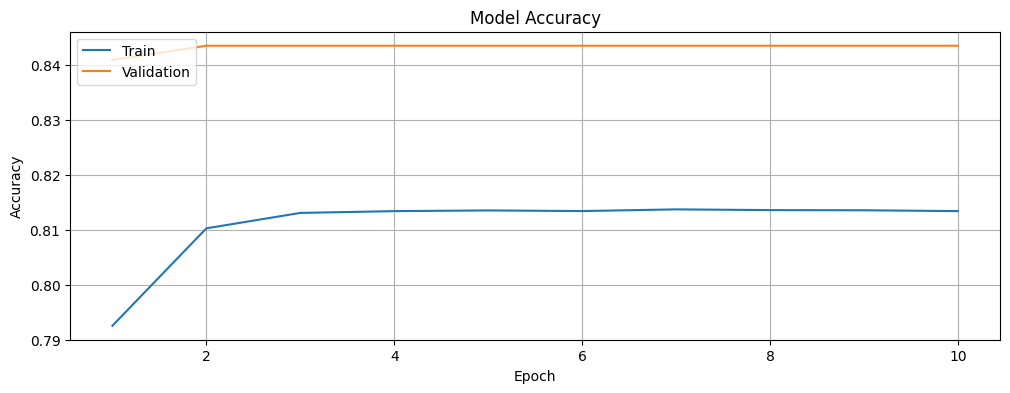

In [40]:
plot_accuracy(history)

Let us plot the training and validation loss of the BERT model.

In [41]:
# Function to plot the training and validation loss.
def plot_loss(history):
  # Plot the training & validation loss values.
  plt.figure(figsize=(12, 4))
  plt.plot(epochs, loss, label='loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Model Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.grid(True)
  plt.show()

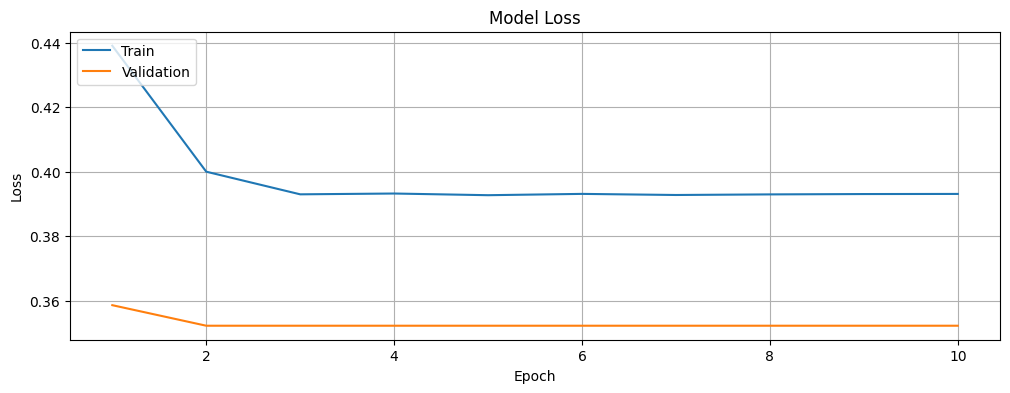

In [42]:
plot_loss(history)

### Test the model with unseen data

We will feed the BERT model with some random text examples and see how it performs.

In [57]:
examples = [
  "I am doing well",
  "The movie was okay.",
  "I have not been keeping well.",
  "It's a bright sunny day, let's go fishing!",
  "Great!",
  "Disaster!",
  "I am feeling confident",
  "I am not feeling confident",
  "The movie is really bad"
]

The function below helps format the examples and their corresponding scores.

In [44]:
# Prints each input text alongside its corresponding model output score.
def print_examples(inputs, results):
  """
  Prints formatted examples with their corresponding scores.

  Parameters:
  - inputs: list of str
      A list of input strings (e.g., text examples) to be printed.
  - results: list of list of float
      A list of lists, where each inner list contains the scores (e.g., model predictions) for the corresponding input.
  """
  # Format and create a list of strings showing each input and its corresponding score.
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()

Before we test with the examples, we will have to tokenize the examples and convert them into TensorFlow-compatible encodings.

In [58]:
# Tokenize the examples and convert them into TensorFlow-compatible encodings.
encoded_examples = tokenizer(
    examples,
    padding='max_length',
    max_length=max_len,
    truncation=True,
    return_tensors='tf')

We will need the input tensors for passing those into our BERT model. Specifically, we will require the `input_ids`, `attention mask`, and `token_type_ids`.

In [59]:
# Extract the input tensors.
input_ids = encoded_examples['input_ids']
attention_masks = encoded_examples['attention_mask']
token_type_ids = encoded_examples.get('token_type_ids', None)

Let us go ahead and pass the three input tensors to the BERT model and get the model's output - the results, stored. The `tf.sigmoid` function converts the raw output (logits) of the BERT model into probabilities / scores that lie between 0 and 1.

In [60]:
# Pass all of the three input tensors to the BERT model.
results = tf.sigmoid(bert_model((input_ids, attention_masks, token_type_ids)))

The next step is to print the BERT model's output and see how the model is performing with the text examples.

In [61]:
print('Results:')
print_examples(examples, results)

Results:
input: I am doing well                : score: 0.719303
input: The movie was okay.            : score: 0.650025
input: I have not been keeping well.  : score: 0.502861
input: It's a bright sunny day, let's go fishing! : score: 0.729490
input: Great!                         : score: 0.729350
input: Disaster!                      : score: 0.504451
input: I am feeling confident         : score: 0.729363
input: I am not feeling confident     : score: 0.503775
input: The movie is really bad        : score: 0.503682



Let us go ahead and define a function that confirms whether the sentiment is *positive* or *negative* based on the score provided by the BERT model and a threshold of 0.5, as mentioned earlier.

In [49]:
# Threshold score that determines the class of a piece of text or tweet.
threshold = 0.5

In [50]:
# Output the sentiment of the given example based on a threshold.
def interpret_results(results, threshold):
  """
  Prints formatted examples with their corresponding scores.

  Parameters:
  - results: list of list of float
      A list of lists, where each inner list contains the scores (e.g., model predictions) for the corresponding input.
  - threshold: float
      A float value representing the threshold score for classifying the examples as positive and negative.
  """
  predictions = []
  for result in results:
      if result <= threshold:
        predictions.append("Negative Sentiment")
      else:
        predictions.append("Positive Sentiment")
  return predictions

We will now go ahead print the sentiments of the example data.

In [51]:
# Interpret the predicted sentiments of the example data.
sentiment_results = interpret_results(results, threshold)

for result in sentiment_results:
    print(result)

Positive Sentiment
Positive Sentiment
Positive Sentiment
Positive Sentiment
Positive Sentiment
Positive Sentiment
Positive Sentiment
Positive Sentiment
Positive Sentiment


### Confusion Matrix

We will also plot the confusion matrix to investigate how the BERT model performs in terms of the false positives and false negatives. Let us first get the test predictions, which are probabilities, and convert them to our labels 0 and 1 based on our threshold of 0.5.

In [53]:
# Predict with the test data.
test_predictions = bert_model.predict(test_ds)
predicted_test_labels = (test_predictions > 0.5).astype("int32")

2/2 [==============================] - 14s 2s/step


Next, we will define and plot the confusion matrix based on the labels in the test data and the labels predicted by the BERT model.

In [54]:
# Confusion matrix.
cm = confusion_matrix(test_labels, predicted_test_labels)

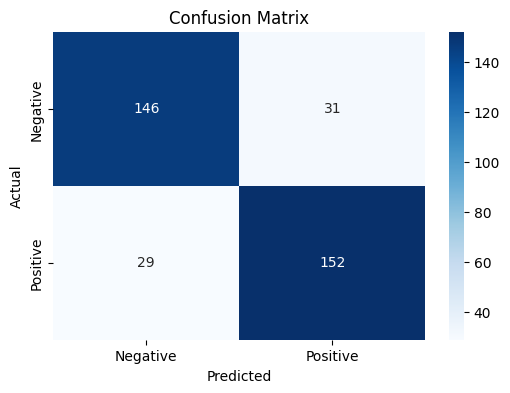

In [55]:
# Plot the confusion matrix.
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Thoughts

The BERt model has an accuracy of about 83% and has about 31 false positives and 29 false negatives out of 358 tweets. The numbers *may* slightly vary across separate occasions of training. However, it is important to note that this is a quick and dirty implementation of a very simple BERT-based model, and the results are not too bad based on the same.

It is also worth noting that while the training and validation loss decreases with time, the accuracy increases, before stabilizing and reaching a stage where there is no further noticeable improvement. Therefore, it is unlikely that we are overfitting or underfitting the data.

Lastly, if we notice carefully, increasing the threshold of the BERT model to a value greater than 0.5 by defining a custom metric will result in a better accuracy value. However, that may give rise to overfitting, and we will have to deal with that separately.

## Next steps

Of course, there is a definite scope for improvement in this work. There are multiple ways to further develop this dirty implementation and improve the BERT model's performance / accuracy for the sentiment analysis of the tweets. Some of those are listed below.



1.   **Modifying the Architecture:** Adding more layers or increasing the number of units in each layer can help the BERT model learn more complex patterns. Using LSTMs (Long Short-Term Memory), Bidirectional LSTMs, or fully connected / dense layers can help.
2.   **Hyperparameter Tuning:** Experimenting with different learning rates, batch sizes, epochs, etc. can help.
3.   **Regularization:** Adjusting dropout rates and the strength of L2 regularization can be used to control overfitting.
4.   **Data Augmentation:** Using techniques to augment the dataset can help, examples below.
  *   **Synonym Replacement:** Replace words with their synonyms.
  *   **Random Insertion:** Insert random words.
  *   **Random Swap:** Swap words in a sentence.
  *   **Random Deletion:** Delete random words.
5.   **Ensemble Methods:** Using ensemble methods such as combining predictions from multiple models can improve performance.
6.   **Hyperparameter Optimization:** Using libraries, such as [Keras Tuner](https://keras.io/keras_tuner/) or [Optuna](https://optuna.org/) to find the best hyperparameters for the BERT model.
7.   **Callbacks:** Using the Trainer API for integrating callbacks, such as EarlyStopping, to optimize the training time and computational resources.

##### **Note:** It is possible to run into compatibility issues with TensorFlow, Transformers, and the TPU environment. The TPU integrated with this Colab notebook has TensorFlow 2.15 installed.